In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.001'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','zoo1C','zoo2C','zoo3C','zoo4C','diatC','x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_diat_zint','photoC_sp_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.001
photoC_TOT_zint
zoo1C
zoo2C
zoo3C
zoo4C
diatC
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
CPU times: user 6.9 s, sys: 2.97 s, total: 9.88 s
Wall time: 12.1 s


In [4]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint
ds['zratio'] = tmp

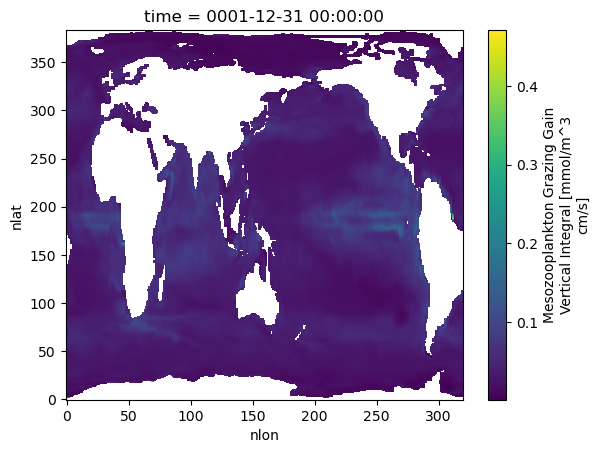

In [5]:
ds.zratio.isel(time=0).plot()

In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [7]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Do correlations NPP and HTL vars

In [8]:
%%time
zoo4C_NPP_ann_corr = xr.corr(ds.zoo4C_zint, ds.photoC_TOT_zint, dim='time')
zoo4C_NPP_ann_corr = zoo4C_NPP_ann_corr.squeeze()

CPU times: user 1.23 s, sys: 2.37 s, total: 3.6 s
Wall time: 3.8 s


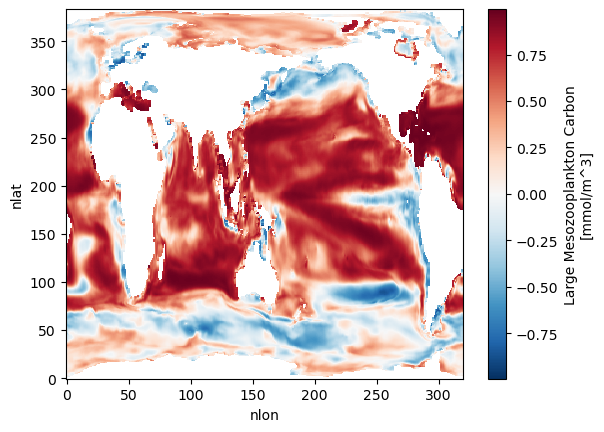

In [9]:
zoo4C_NPP_ann_corr.plot()

In [10]:
%%time
zratio_NPP_ann_corr = xr.corr(ds.zratio, ds.photoC_TOT_zint, dim='time')
zratio_NPP_ann_corr = zratio_NPP_ann_corr.squeeze()

CPU times: user 283 ms, sys: 308 ms, total: 591 ms
Wall time: 596 ms


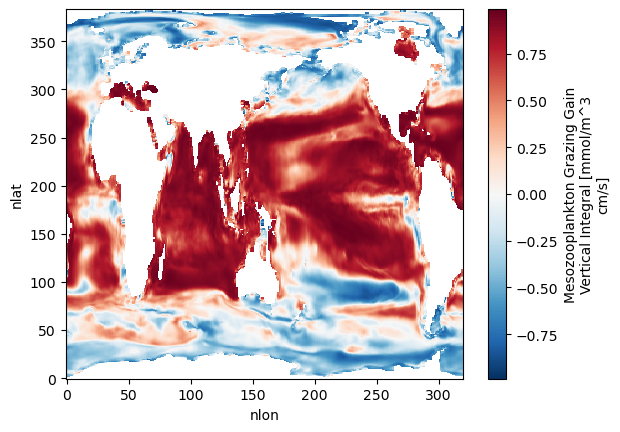

In [11]:
zratio_NPP_ann_corr.plot()

In [12]:
%%time
zoo3C_NPP_ann_corr = xr.corr(ds.zoo3C_zint, ds.photoC_TOT_zint, dim='time')
zoo3C_NPP_ann_corr = zoo3C_NPP_ann_corr.squeeze()

CPU times: user 1.21 s, sys: 2.25 s, total: 3.46 s
Wall time: 3.54 s


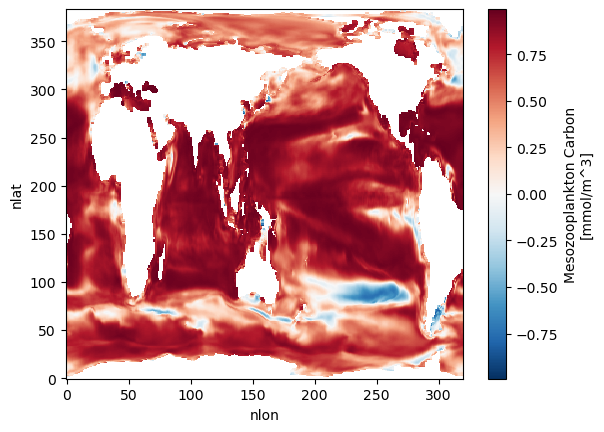

In [13]:
zoo3C_NPP_ann_corr.plot()

### Correlations between NPP and other biomass/production

In [14]:
%%time
zoo2C_NPP_ann_corr = xr.corr(ds.zoo2C_zint, ds.photoC_TOT_zint, dim='time')
zoo2C_NPP_ann_corr = zoo2C_NPP_ann_corr.squeeze()

CPU times: user 1.51 s, sys: 2.6 s, total: 4.12 s
Wall time: 4.34 s


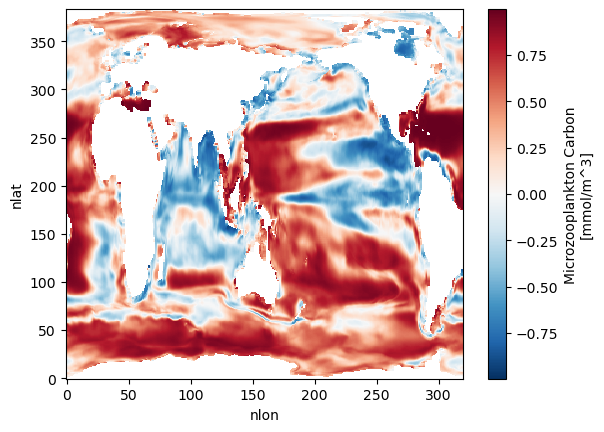

In [15]:
zoo2C_NPP_ann_corr.plot()

In [16]:
%%time
zoo1C_NPP_ann_corr = xr.corr(ds.zoo1C_zint, ds.photoC_TOT_zint, dim='time')
zoo1C_NPP_ann_corr = zoo1C_NPP_ann_corr.squeeze()

CPU times: user 1.18 s, sys: 2.14 s, total: 3.32 s
Wall time: 3.46 s


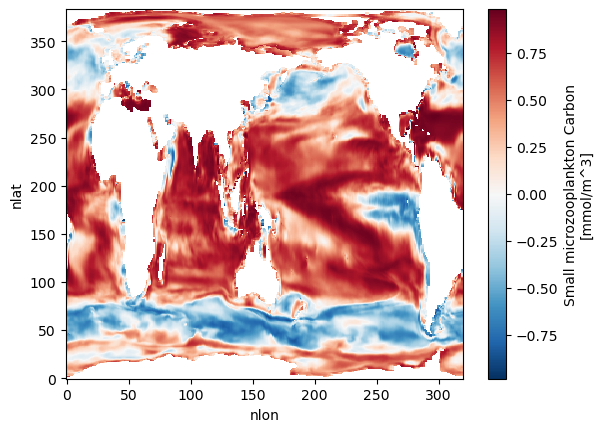

In [17]:
zoo1C_NPP_ann_corr.plot()

In [18]:
%%time
diatC_NPP_ann_corr = xr.corr(ds.diatC_zint, ds.photoC_TOT_zint, dim='time')
diatC_NPP_ann_corr = diatC_NPP_ann_corr.squeeze()

CPU times: user 1.36 s, sys: 2.45 s, total: 3.81 s
Wall time: 3.91 s


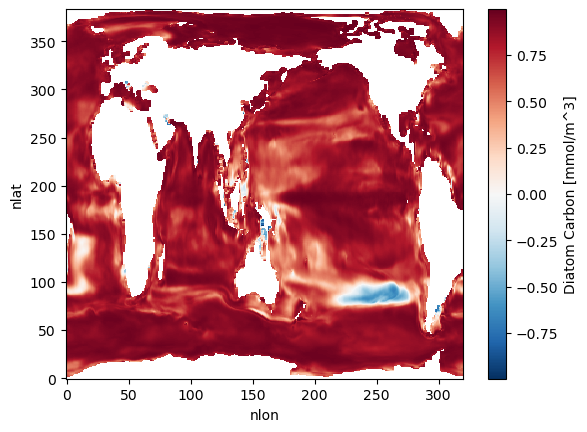

In [19]:
diatC_NPP_ann_corr.plot()

In [20]:
%%time
diatNPP_NPP_ann_corr = xr.corr(ds.photoC_diat_zint, ds.photoC_TOT_zint, dim='time')
diatNPP_NPP_ann_corr = diatNPP_NPP_ann_corr.squeeze()

CPU times: user 248 ms, sys: 66.3 ms, total: 314 ms
Wall time: 362 ms


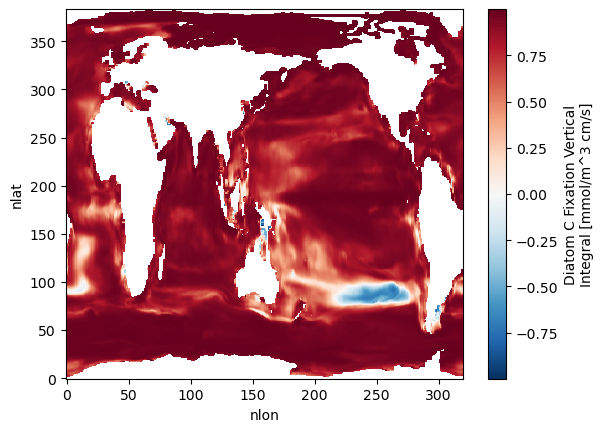

In [21]:
diatNPP_NPP_ann_corr.plot()

In [22]:
%%time
spNPP_NPP_ann_corr = xr.corr(ds.photoC_sp_zint, ds.photoC_TOT_zint, dim='time')
spNPP_NPP_ann_corr = spNPP_NPP_ann_corr.squeeze()

CPU times: user 243 ms, sys: 95.4 ms, total: 338 ms
Wall time: 335 ms


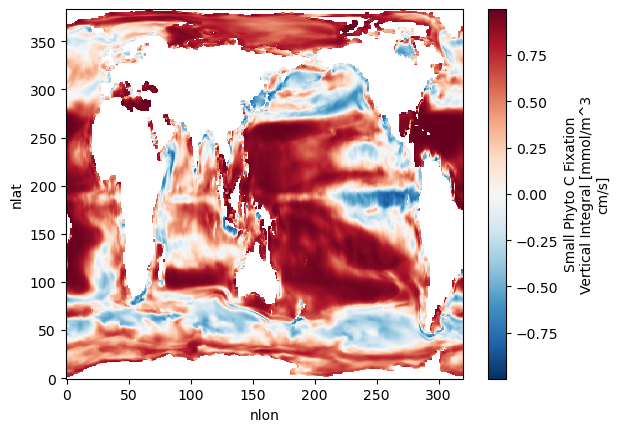

In [23]:
spNPP_NPP_ann_corr.plot()